# Humany Activity Recognition (HAR) using wearables


---


In this script we apply the HAR algorithm developed with the DaiLAc dataset on the [mHealth dataset](http://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset).  The mHealth dataset contains accelerometer, gyroscope, magnetometer data (three axes) recorded by body-worn sensors while subjects were performing different activities. The sensors were placed at the lower arm and the ankle. In addition, a device placed on the chest recorded accelerometer data and two ECG leads. 

Data for the activities were collected in an out-of-lab environment with no constraints on the way these must be executed, with the exception that the subject should try their best when executing them. The activities performed were the following:

L1: Standing still (1 min) 
L2: Sitting and relaxing (1 min) 
L3: Lying down (1 min) 
L4: Walking (1 min) 
L5: Climbing stairs (1 min) 
L6: Waist bends forward (20x) 
L7: Frontal elevation of arms (20x)
L8: Knees bending (crouching) (20x)
L9: Cycling (1 min)
L10: Jogging (1 min)
L11: Running (1 min)
L12: Jump front & back (20x)

Analysis of ECG is beyond the scope of this project, and we focus only on accelerometer, gyroscope and magnetometer data, which help determine the momvement and orientation of the body. 

The purpose of the excercice is twofold. First, it helps assess the performance of an algorithm (using various models) in detecting different activites. Second, it gives us an insight as to the ability of an algorithm developed to address specific HAR tasks (the DaiLAc dataset), to generelize to a different problem (the mHealth dataset). 

We start by setting our working directory and importing the necessary libraries, including our utilities file. 

In [0]:
from har_utils import *
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Dailac


We set the paramters of the raw datasets we are going to read in and set the parameters used later in the data processing.

In [0]:
colnames = ["A_chest_1", "A_chest_2", "A_chest_3", 
 "ECG_1", "ECG_2",
 "A_ankle_1", "A_ankle_2", "A_ankle_3",
 "G_ankle_1", "G_ankle_2", "G_ankle_3",
 "M_ankle_1", "M_ankle_2", "M_ankle_3",
 "A_wirst_1", "A_wrist_2", "A_wrist_3",
 "G_wrist_1", "G_wrist_2", "G_wrist_3",
 "M_wrist_1","M_wrist_2", "M_wrist_3", "label"]
sf = 50 #samling frequency in herz
wl = int(sf*5)#window length
ol = wl//2 #window overlap (50%)
n_subjs = 10
n_cols = 41 #no. of columns for signals after preprocessing
n_features = 25 # no. of columns per signal
activities = ["None", "stand", "sit", "lie", "walk", "stairs", "bend", "arms_up",
              "crouch", "cycle", "jog", "run", "jump"]


For the ten subjects, we read the data in, low-pass and high-pass filter the accelerometer data and Fourier transform the data. The data is reshaped from an array of dimensions (n_samples, n_signals) into windows with a 50% overlap of dimensions (n_windows, window length, n_signals).

In [0]:
scaler = StandardScaler()
#list to store data by subject
SIGNALS = []#list to store signals
FT = []#to store Fourier transformed signals
Y = []#to store labels

for subj in range(n_subjs): 
  #reading
  raw = pd.read_csv("mhealth/mHealth_subject" + str(subj+1) + ".log",
                    sep = "\t", header = None, names = colnames)
  labels = raw.label.values
  raw.drop(labels = "label", axis = 1, inplace = True)
  #extracting AC and DC components and concatenating
  acc = raw.loc[:, raw.columns.str.match("^A_")]
  AC, DC = get_AC_DC(acc.values, sf, 1,2)
  AC.columns = ["AC_" +a for a in acc.columns.to_list()]
  DC.columns = ["DC_" +a for a in acc.columns.to_list()]
  other = raw.loc[:, ~raw.columns.str.match("^A_")]
  X = pd.concat([acc, other, AC, DC], axis = 1)
  final_cols = X.columns
  #rescale
  X = scaler.fit_transform(X)
  #reshaping labels
  y = reshape_to_windows(labels, wl, ol[:, wl//2] #labels at center of window

  #empty arrays for raw data, fourier transformed data
  n_cols = acc.shape[1] + other.shape[1] + AC.shape[1] + DC.shape[1]
  signals = np.zeros((y.shape[0], wl, n_cols))
  ft = np.empty((y.shape[0], wl, n_cols), np.complexfloating)
  #reshaping signals and taking Fourier transform
  for col in range(X.shape[1]):
    x = reshape_to_windows(X[:,col], wl, ol)
    x_ft = np.fft.fft2(x-np.mean(x, axis = 1)[:,None])/wl
    signals[:, :, col] = x
    ft[:, :, col] = x_ft
  
  SIGNALS.append(signals)
  FT.append(ft)
  Y.append(y)


Let's have a first look into the data. We plot 500 samples (10 seconds) of anlke and wrist acceleration (along axis 2). The activities are visually quite distinct, apart from the 'None' (null) activity. Indeed, while all other activities are performed at the experimenter's request as part of protocol, the null activity can be any activity. 

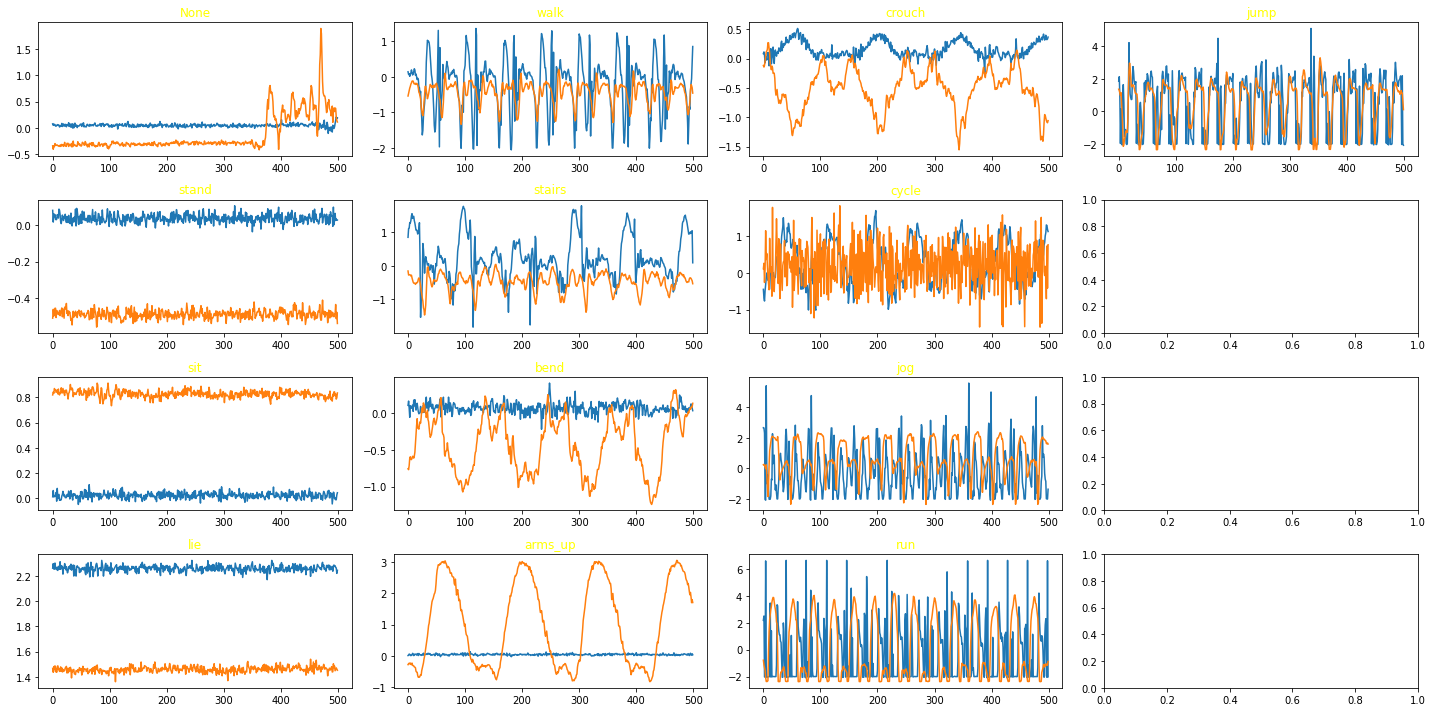

In [0]:
import matplotlib.pyplot as plt
ankle2 = final_cols == "A_ankle_2"
wrist2 = final_cols== "A_wrist_2"
fig, ax = plt.subplots(4,4, figsize = (20,10))
for i, act in enumerate(activities):
  act_ind = labels==i
  ax[i%4,i//4].plot(X[act_ind,ankle2][:500])
  ax[i%4,i//4].plot(X[act_ind,wrist2][:500])
  ax[i%4,i//4].set_title(act, {'color':"yellow"})
  fig.tight_layout()




**Feature extraction**

We extract the features (temporal and frequential) using customized functions

In [0]:
FEATS = []
for i in range(n_subjs):
  X = SIGNALS[i]
  ft = FT[i]
  feats = np.zeros((X.shape[0], n_features*n_cols))
  for col in range(n_cols):
    temp_feats, temp_names = extract_temporal_features(X[:,:,col])#get features and names of features
    freq_feats, freq_names = extract_frequential_features(ft[:,:,col], sf)
    feats[:, (col*n_features):(col*n_features+n_features)] =\
     np.concatenate([temp_feats, freq_feats], axis = 1)
  FEATS.append(feats)
feat_names = [col+f_name for col in final_cols for f_name in temp_names + freq_names] #array of feature names

We concatenate data for all subjects together and add an index for subject

In [0]:
SUBJ = np.repeat(range(n_subjs),[y.size for y in Y])
Y = np.concatenate(Y)
FEATS = np.concatenate(FEATS)
SIGNALS = np.concatenate(SIGNALS)
FT = np.concatenate(FT)

We do not focus on cardiac signals, so we remove ECG-related features from the analysis. We scale the features.

In [0]:
FEATS = FEATS[:, ~pd.Index(feat_names).str.match("^ECG")]
FEATS = scaler.fit_transform(FEATS)

#**Training and testing classical models**

---

We define different functions for instantiating classifiers



In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

def set_GB():
    return GradientBoostingClassifier(n_estimators = 500,
                                        max_features = 10, 
                                        max_depth = 3,
                                      n_iter_no_change = 5, 
                                      validation_fraction = 0.3, 
                                      learning_rate = 0.05)
def set_RF():
  return RandomForestClassifier(n_estimators = 500 , n_jobs=-1)
def set_logreg():
    return LogisticRegression(multi_class = "auto", penalty = 'l2', solver = "lbfgs", n_jobs = -1)
def set_SVM():
  return SVC()
def set_knn():
  return KNeighborsClassifier(n_neighbors = 5)

We iteratively train the data on all the subject but one, and test on the latter. The accuracy score is the average for all iterations. 

The null class is kept out during training, as it does not correspond to any specific activity. In the testing part, we apply the algorithm to all data, including those labelled as null, to assess the algorithm's ability to detect the classes of interest. The accuracy score is calculated as the porportion of non-null classes that were correctly predicted.

In [0]:
scores = []#list for score for each leave-one-out iteration
cms = []
for i in range(10):
  mask = SUBJ==i#test subject
  null = Y==0
  X_train = FEATS[~mask & ~null, :]
  y_train = Y[~mask & ~ null]
  #training hierarchical classifiers
  clf  = set_logreg()
  clf.fit(X_train, y_train)
  X_test = FEATS[mask,:]
  y_test = Y[mask]
  y_pred = clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[1:,1:]
  score = np.diag(cm).sum()/cm.sum()
  cms.append(cm)
  scores.append(score)
  print("accuracy tested on subject {}: {}".format(i, score))
print("mean accuracy: {}".format(np.mean(scores)))
print("standard deviation of accuracy: {}".format(np.std(scores)))

accuracy tested on subject 0: 0.9893238434163701
accuracy tested on subject 1: 0.9859154929577465
accuracy tested on subject 2: 0.911660777385159
accuracy tested on subject 3: 1.0
accuracy tested on subject 4: 0.996309963099631
accuracy tested on subject 5: 0.9922779922779923
accuracy tested on subject 6: 1.0
accuracy tested on subject 7: 0.9516728624535316
accuracy tested on subject 8: 1.0
accuracy tested on subject 9: 0.9888059701492538
mean accuracy: 0.9815966901739686
standard deviation of accuracy: 0.026950729281424477


#**Training and testing a CNN model**

We define the CNN architecture

In [0]:
from keras.models import Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, Input, concatenate
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
def get_cnn(kern, pool_size, n, n_cols, n_output):
  """cnn with 1-layer of 1d convulutions with kern size (kern), max-pooling with
  size (pool_size). The model tunes n filters (n).
  Input: [raw signals shaped (window size, no. of signals (n_cols)), 
  fourier transform of the signals shaped (window size//2, no. of signals (n_cols))]
  Output: Matrices with prediction probabilities for n classes (n_output)
  """

  inp_raw = Input(shape=(int(wl), n_cols))
  inp_FT = Input(shape=(int(wl)//2, n_cols))

  raw = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(inp_raw)
  raw = BatchNormalization()(raw)
  raw = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(raw)
  raw = BatchNormalization()(raw)
  raw = MaxPooling1D(pool_size = pool_size, padding = "same")(raw)
  raw = Flatten()(raw)

  FT = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(inp_FT)
  FT = BatchNormalization()(FT)
  FT = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(FT)
  FT = BatchNormalization()(FT)
  FT = MaxPooling1D(pool_size = pool_size, padding = "same")(FT)
  FT = Flatten()(FT)
  # merge
  z = concatenate([raw, FT])
  z = Dropout(0.3)(z)
  z = BatchNormalization()(z)
  z = Dense(n_output, activation="softmax")(z)
  model = Model(inputs = [inp_raw, inp_FT], outputs = z)
  model.compile(optimizer='adam', loss = 'categorical_crossentropy',
                metrics = ['mse', 'accuracy'])
  return model

Using TensorFlow backend.


We select the relevant data

In [0]:
FT = np.abs(FT[:,:wl//2,:])#we take the modulus of the Fourier transform (complex numbers) and discard the redundant half
#remove ECG
SIGNALS = SIGNALS[:, :, ~pd.Index(final_cols).str.match("^ECG")]
FT = FT[:, :, ~pd.Index(final_cols).str.match("^ECG")]
n_cols = FT.shape[2]

In [0]:
esm = EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights=True)
#lists for storing confusion matrices and accuracy scores
cms, scores = [], []

for subj in range(10):
  print(subj)
  mask = SUBJ==subj #sample indices for test subject
  null = Y==0
  X_train = [SIGNALS[~mask & ~null], FT[~mask & ~null]]
  X_test = [SIGNALS[mask], FT[mask]]#preparing data for cnn
  y_train = Y[~mask & ~null] #target values for train subjects
  y_train = to_categorical(y_train) #one-hot encoding for target values
  y_true = Y[mask] #target values for test
  clf = get_cnn(2**3, 2**4, n_cols, n_cols, y_train.shape[1]) #cnn model
  clf.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks = [esm], verbose = 1)
  y_pred = clf.predict(X_test).argmax(axis = 1) #prediction as categorical vector
  cm = confusion_matrix(y_true, y_pred)[1:,1:]
  score = np.diag(cm).sum()/cm.sum()
  cms.append(cm)
  scores.append(score)
  print("score: " +str (score))
print(("mean score ") + str(np.mean(scores)))
print("standard deviation of accuracy: {}".format(np.std(scores)))
  


0
Train on 1726 samples, validate on 740 samples
Epoch 1/30
1726/1726 [==============================] - 8s 5ms/step - loss: 0.8997 - mse: 0.0299 - accuracy: 0.7121 - val_loss: 0.7424 - val_mse: 0.0289 - val_accuracy: 0.7284
Epoch 2/30
1726/1726 [==============================] - 1s 644us/step - loss: 0.0814 - mse: 0.0025 - accuracy: 0.9815 - val_loss: 0.3541 - val_mse: 0.0129 - val_accuracy: 0.9135
Epoch 3/30
1726/1726 [==============================] - 1s 708us/step - loss: 0.0357 - mse: 9.6882e-04 - accuracy: 0.9925 - val_loss: 0.3407 - val_mse: 0.0128 - val_accuracy: 0.8851
Epoch 4/30
1726/1726 [==============================] - 1s 739us/step - loss: 0.0191 - mse: 3.6739e-04 - accuracy: 0.9983 - val_loss: 0.3148 - val_mse: 0.0121 - val_accuracy: 0.8986
Epoch 5/30
1726/1726 [==============================] - 1s 692us/step - loss: 0.0118 - mse: 2.1717e-04 - accuracy: 0.9994 - val_loss: 0.3107 - val_mse: 0.0121 - val_accuracy: 0.8932
Epoch 6/30
1726/1726 [=============================

#**Conclusion** 
We have applied an algorithm developed to address the classification problem presented by the DaiLAc dataset to that presented by the mHealth dataset. For the DaLiAc dataset, the CNN performed almost as good as the logistic regression relying on engineered features (94.7% vs 97.3%). In contrast, While the same logistic regression algorithm performed very well (98.2% accuracy) on the mHealth dataset, the CNN yielded relatively poor results (88.4%). This points to a poorer generalisability of the our CNN compared to the logistic regression. 